# Морфология 2
В данном ноутбуке находится задание на триграммы и словарь. В качестве текста будем использовать томик войны и мира: https://goo.gl/qcVTLE 

Для начала напомним некоторые полезные инструменты на питоне

## 1. Инструменты

### 1.1. Регулярные выражения
Исчерпывающий пост https://habr.com/ru/post/349860/

In [114]:
import re
import numpy as np
from collections import Counter
import itertools
from itertools import product


# С помощью рег. выражения можно искать, заменять и сентезировать строки по шаблонам
# Парочка простых примеров
numbers = re.findall(r'\d+', r'There is some numbers: 49 and 432')
print (u'Находим числа в строке: ', numbers)

print ( u'Простенький токенизатор: ', re.sub('[,\.?!]',' ','How, to? split. text!').split())

print (u'Еще один токенизатор: ', re.split(r'\W+', 'How, to? split. text! Again'))

# в качестве тренировки придумайте свой токенизатор в случае, когда из текста нужно получить только русские слова.
print(u'Русский токенизатор:', re.sub(r'[^А-я]', ' ', 'Русский алфавит english 12345 -&!?').split())

Находим числа в строке:  ['49', '432']
Простенький токенизатор:  ['How', 'to', 'split', 'text']
Еще один токенизатор:  ['How', 'to', 'split', 'text', 'Again']
Русский токенизатор: ['Русский', 'алфавит']


### 1.2. Чтение файлов
Чтобы не мучится самим с кодировками, приведем способ чтения файла корпуса.

In [77]:
import io
wordlilist = None
with io.open('wp.txt', "r", encoding='utf-8') as text_file:
    text = text_file.read()
    wordlist = re.sub(r'[^А-я]', ' ', text.lower()).split()

### 1.3. ООП
В питоне можно создавать свои классы, скорее всего нам понадобится класс для хранения бора

In [96]:
class Node:

    def __init__(self, char):
        self.char = char
        self.children = {}
        
        self.end_flg = False

class Trie(object):
    def __init__(self):
        self.root = Node("")
    
    def insert(self, word):
        node = self.root
        
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = Node(char)
                node.children[char] = new_node
                node = new_node
        
        node.end_flg = True

    def depth_search(self, node, curr_word, word, counter, mistakes):
        
        if counter + 1 > len(word):
            return
         
        curr_word = curr_word + node.char
        if word[counter] != node.char:
            mistakes += 1

        counter += 1
            
        if node.end_flg:
            compl_mist=0
            if len(word) > len(curr_word):
                compl_mist += mistakes + len(word) - len(curr_word)
            else:
                compl_mist = mistakes
                
            self.output.append([curr_word, compl_mist])
        for child in node.children.values():
            self.depth_search(child, curr_word, word, counter, mistakes)
        
    def correction(self, word):
        '''
        word: word to correct form
        '''
        self.output = []

        for child in self.root.children.values():
            self.depth_search(child, '', word, 0, 0)
            
        retult_arr = np.array(self.output)
        if retult_arr.shape[0]== 0:
            return retult_arr
        else:
            retult_arr = retult_arr[retult_arr[:,1].argsort()]
            
            return retult_arr

In [97]:
# test on a simple example
t = Trie()
t.insert("лошадь")
t.insert("лодка")
t.insert("слон")
t.insert("лодья")
t.correction("лошадка")[0]

array(['лошадь', '2'], dtype='<U6')

### 1.4. pyplot
Довольно часто приходится построить какие-нибудт графики и гистограммы для изучения данных, с которыми придется работать. Для этого в питоне есть удобнейший модуль для этого - pyplot. Туториал: https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html

In [13]:
#!pip install matplotlib # Установка модуля
import matplotlib.pyplot as plt
# команда чтобы картинки рисовались прямо в ноутбуке
%matplotlib inline 

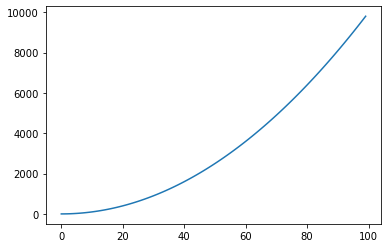

In [14]:
# Посмотрим на график функции x^2
data = [i * i for i in range(100)]
plt.plot(data)

(array([32., 13., 10.,  8.,  8.,  6.,  6.,  6.,  5.,  6.]),
 array([   0. ,  980.1, 1960.2, 2940.3, 3920.4, 4900.5, 5880.6, 6860.7,
        7840.8, 8820.9, 9801. ]),
 <BarContainer object of 10 artists>)

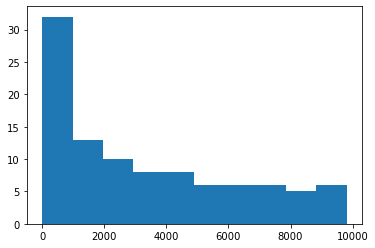

In [15]:
# и распределение по значениям
plt.hist(data)

Также полезная команда для подсчета времения выполнеия в ячейке

In [16]:
%%time
res = 0
for i in range(int(1e8)):
    res += 1

Wall time: 8.6 s


## 2. Задание
Собственно теперь нам потребуется написать подсчет триграмм и бор для словаря, чтобы реализовать простенькую систему исправления ошибок.

### 2.1. Триграммы
Для начала получим словарь триграмма - её кол-во в тексте, не забывая о начале и конце слова.

Далее можно построить гистограмму на кол-во вхождений триграмм, и посмотреть самые частые и какая частота у каких-нибудь заведомо странных, например: 'чгк', 'шкя' и подобные. Из полученных данных придумать эвристику, как считать слово с опечаткой. Проверить эвристику по словарю.

In [32]:
def corpus_trigrams(word_list):
    '''returns trigrams count dictionary'''
    gram_arr = []

    for i in range(len(word_list)):
        gram_arr.append(word_list[i][0])
        gram_arr.append(word_list[i][:2])
        
        for j in range (len(word_list[i])):
            gram_arr.append( word_list[i][j:j+3])

    result = dict(Counter(gram_arr))
    return result

In [33]:
simple_test = ['кактус', 'матрешка']

In [34]:
corpus_trigrams(simple_test)

{'к': 1,
 'ка': 2,
 'как': 1,
 'акт': 1,
 'кту': 1,
 'тус': 1,
 'ус': 1,
 'с': 1,
 'м': 1,
 'ма': 1,
 'мат': 1,
 'атр': 1,
 'тре': 1,
 'реш': 1,
 'ешк': 1,
 'шка': 1,
 'а': 1}

In [35]:
dict_war_trigramm = corpus_trigrams(wordlist)

In [48]:
def proc_dict(word_dict):
    '''Delete 10% of most rare three-grams.'''
    num_elem = int(0.1 * len(word_dict))
    sorted_word_dict = {k: v for k, v in sorted(word_dict.items(), key=lambda item: item[1])}
    
    res_dict = {}
    
    for key in sorted_word_dict:
        num_elem -= 1
        if num_elem<0:
            res_dict[key] = word_dict[key]
            
    return res_dict

In [49]:
dict_war_trigramm_proc = proc_dict(dict_war_trigramm)

In [59]:
def is_error(word):
    '''is the word with mistake'''
    
    for j in range (len(word)):
        tgram = word[j:j+3]
        if tgram not in dict_war_trigramm_proc:
            return True
    return False

In [60]:
is_error('ложка')

False

In [61]:
is_error('лошка')

True

### 2.2. Бор
Далее построим бор, с помощью которого будем искать исправления опечатки в слове. Пока только в случае замены и удаления в конце (Если есть желание, то можно и для всех случаев). Также сравнить по времени с поиском в случае замены в исходном слове последних двух символов и поиске в словаре.

In [98]:
trie_dict = Trie()

for word in wordlist:
    trie_dict.insert(word)

In [101]:
def correct_word(word):
    '''returns most similar word from dictionary'''
    result = trie_dict.correction(word)[0][0]
    return result 

In [106]:
correct_word('лошь') # понятно, что в данном случае ошибка скорее всего была в слове "ложь", но так как мы не уитывали
                    # дополнительные параметры, то такой вариант тоже приемлем

'лишь'

In [107]:
correct_word('салнце') 

'солнце'

In [109]:
a = ord('а')
a

1072

In [111]:
alp_str = ''.join([chr(i) for i in range(a,a+32)])
alp_str

'абвгдежзийклмнопрстуфхцчшщъыьэюя'

In [115]:
   def correct_word_naive(word):
    '''correct word using generation'''
        
    abc = 'абвгдежзийклмнопрстуфхцчшщъыьэюя'
    combinations = [''.join(i) for i in product(alp_str, repeat = 2)]
    words_to_check = []
    for comb in combinations:
        cur_word = word[:-2] + comb
        if cur_word in wordlist:
            return cur_word

In [119]:
correct_word_naive('дожyi')

'дождя'

### 2.3 Все вместе
Теперь соберем поиск и исправление опечаток в одну систему, которая будет принимать текст и править его. Также замерим скорость по сравнению с "менее наивным подходом".

In [125]:
def correct_mistakes(text):
    '''returns corrected text'''
    text = text
    text_arr = re.sub(r'[^А-я]', ' ', text.lower()).split()
    correct_text = []
    for i in range(len(text_arr)):
        correct_text.append(correct_word(text_arr[i]))
        
    return ' '.join(correct_text)

def correct_mistakes_naive(text):
    '''returns corrected text using generation'''
    text_arr = re.sub(r'[^А-я]', ' ', text.lower()).split()
    correct_text = []
    for i in range(len(text_arr)):
        correct_text.append(correct_word_naive(text_arr[i]))        
    return ' '.join(correct_text)

In [129]:
simple_test = 'Дожшь, нево, солнсе'

In [130]:
%%time
correct_mistakes(simple_test)

Wall time: 88 ms


'поешь ново солнце'

In [131]:
%%time
correct_mistakes_naive(simple_test)

Wall time: 2.91 s


'дождя неба солнца'